In [1]:
import pandas as pd
from typing import List
import glob
import pathlib
import re
import matplotlib as mpl
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

#matplotlib.use('TkAgg')

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

AXIS_LABELS = {
    "nacc": r"$C_{N}$ Accuracy",
    "oacc": r"$C_{O}$ Accuracy",
    "av_acc": r"Average ($C_{O},C_{N}$) Accuracy",
    "macc": "Macro-accuracy",
    "vacc": "rAverage ($C_{O},C_{N}$) Accuracy",
    "f1": "F1-Score"
}

MARKERS = ['v','X','>', 'o','s','p', 'P', '*', 'D', 'd', '<', 'H', '3']

# get latex files
latex_files = []
folders = [33, 66, "mid", "high", "low"]
for folder in folders:
    latex_files.extend(glob.glob(f'/Users/kimathikaai/scratch/saved/domainbed_results/{folder}/*.tex', recursive=True))
    
print("Number of latex Files: ", len(latex_files))
assert len(latex_files) == len(folders) * 6 * 6

# convert latex documents to a pandas dataframe
from results import scrape_latex
data = []
# scrape each latex file
for file in latex_files:
    #print('[info] processing: ', file)
    data.extend(scrape_latex(file))

# convert to pandas data frame
df = pd.DataFrame.from_dict(data)

Number of latex Files:  180


# Ablations
- Imposing fairnes (POXL) increases (nacc,nacc) and (acc,acc) than without (POXL-F) for (PACS, 33, 66)
- (POXL+B) is better than (POXL) for lower overlap (PACS, 33) but not for higher overlap
    - More difficult to impose fairness with less overlapping data
- Including alpha+beta is benefical for (acc, acc, PACS, 33, 66) (POXL-F-A vs POXL-F+B)
    - (nacc, nacc, PACS, 66) alpha+beta is more beneficial
    - (nacc, nacc, PACS, 33) alpha+beta is less beneficial

In [2]:
data = df.loc[(df['evaluation_metric'].isin(['nacc', 'macc']))&(df['selection_metric'].isin(['macc','nacc']))&(df['dataset'].isin(['PACS', 'OfficeHome']))&(df['overlap'].isin(['33', '66']))][df['algorithm'].str.contains('POXL')].sort_values(by='algorithm', ascending=True).reset_index(drop=True)
pd.pivot_table(data=data, values='evaluation_value', index=['selection_metric', 'evaluation_metric','algorithm'], columns=['dataset', 'overlap'], aggfunc=np.mean)

/var/folders/kr/gtghwjcs55q1lrp82b0qv62h0000gn/T/ipykernel_55084/569162712.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data = df.loc[(df['evaluation_metric'].isin(['nacc', 'macc']))&(df['selection_metric'].isin(['macc','nacc']))&(df['dataset'].isin(['PACS', 'OfficeHome']))&(df['overlap'].isin(['33', '66']))][df['algorithm'].str.contains('POXL')].sort_values(by='algorithm', ascending=True).reset_index(drop=True)


dataset                                      OfficeHome        PACS      
overlap                                              33    66    33    66
selection_metric evaluation_metric algorithm                             
macc             macc              POXL            47.9  53.7  49.0  59.9
                                   POXL+B          47.5  53.9  50.2  58.0
                                   POXL-F          47.6  55.3  48.9  58.3
                                   POXL-F+B        47.3  54.7  49.0  59.1
                                   POXL-F-A        47.6   NaN  48.6  58.9
                 nacc              POXL            40.9  39.8  34.2  14.9
                                   POXL+B          40.3  40.6  35.3  11.6
                                   POXL-F          40.5  40.3  34.2  13.0
                                   POXL-F+B        40.2  39.9  34.1  14.8
                                   POXL-F-A        40.9   NaN  33.7  13.1
nacc             macc              POXL            47.4  52.1  49.1  57.3
                                   POXL+B          46.9  52.6  49.8  57.8
                                   POXL-F          47.8  55.3  47.4  59.4
                                   POXL-F+B        47.5  53.9  49.4  57.4
                                   POXL-F-A        47.9   NaN  49.1  59.0
                 nacc              POXL            40.9  41.3  35.2  20.4
                                   POXL+B          40.3  40.6  35.3  19.1
                                   POXL-F          41.0  41.7  33.2  15.4
                                   POXL-F+B        40.6  40.8  35.3  17.5
                                   POXL-F-A        41.0   NaN  35.4  17.3

# Relationships Between Metrics
- Determine what `selection_metric` is a good indicator for a specific `evaluation_metric`

In [3]:
df.loc[(df['selection_metric'].isin(['nacc', 'acc'])) &(df['evaluation_metric'].isin(['nacc','acc']))
#].groupby(['dataset', 'overlap', 'selection_metric', 'evaluation_metric']).mean(numeric_only=True)
].groupby(['dataset','selection_metric', 'evaluation_metric']).mean(numeric_only=True)

evaluation_value  \
dataset    selection_metric evaluation_metric                     
OfficeHome acc              acc                       49.911111   
                            nacc                      39.188889   
           nacc             acc                       49.514815   
                            nacc                      39.477778   
PACS       acc              acc                       53.486667   
                            nacc                      28.628889   
           nacc             acc                       53.182222   
                            nacc                      30.613333   
VLCS       acc              acc                       46.762500   
                            nacc                      40.204167   
           nacc             acc                       44.625000   
                            nacc                      49.762500   

                                               evaluation_std  
dataset    selection_metric evaluation_metric                  
OfficeHome acc              acc                      0.411111  
                            nacc                     0.470370  
           nacc             acc                      0.444444  
                            nacc                     0.448148  
PACS       acc              acc                      0.593333  
                            nacc                     0.844444  
           nacc             acc                      0.797778  
                            nacc                     1.037778  
VLCS       acc              acc                      0.766667  
                            nacc                     1.458333  
           nacc             acc                      1.291667  
                            nacc                     2.050000

### What is  the AVERAGE performance ACROSS DATASETS for each overlap and metric?

In [4]:
df.groupby(['overlap', 'selection_metric', 'evaluation_metric', 'algorithm']).mean()

/var/folders/kr/gtghwjcs55q1lrp82b0qv62h0000gn/T/ipykernel_55084/2889167385.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby(['overlap', 'selection_metric', 'evaluation_metric', 'algorithm']).mean()


evaluation_value  \
overlap selection_metric evaluation_metric algorithm                      
33      acc              acc               ARM                45.800000   
                                           CAD                44.433333   
                                           CORAL              47.466667   
                                           ERM                46.400000   
                                           Intra              46.833333   
                                           Intra_XDom         47.500000   
                                           MLDG               45.733333   
                                           POXL               46.666667   
                                           POXL+B             47.300000   
                                           POXL-F             47.033333   
                                           POXL-F+B           47.900000   
                                           POXL-F-A           47.900000   
                                           SelfReg            46.066667   
                                           Transfer           45.700000   
                                           XDomBatch          46.100000   
                                           XMLDG              47.333333   
                         f1                ARM                41.266667   
                                           CAD                39.433333   
                                           CORAL              42.700000   
                                           ERM                41.466667   
                                           Intra              42.133333   
                                           Intra_XDom         41.800000   
                                           MLDG               41.566667   
                                           POXL               42.066667   
                                           POXL+B             42.933333   
                                           POXL-F             42.933333   
                                           POXL-F+B           43.250000   
                                           POXL-F-A           43.350000   
                                           SelfReg            41.166667   
                                           Transfer           41.133333   
                                           XDomBatch          39.900000   
                                           XMLDG              43.233333   
                         macc              ARM                47.200000   
                                           CAD                45.600000   
                                           CORAL              48.500000   
                                           ERM                47.800000   
                                           Intra              48.233333   
                                           Intra_XDom         49.700000   
                                           MLDG               47.866667   
                                           POXL               48.066667   
                                           POXL+B             48.966667   
                                           POXL-F             48.533333   
                                           POXL-F+B           48.550000   
                                           POXL-F-A           48.500000   
                                           SelfReg            47.033333   
                                           Transfer           47.366667   
                                           XDomBatch          48.200000   
                                           XMLDG              48.900000   
                         nacc              ARM                38.233333   
                                           CAD                37.833333   
                                           CORAL              39.366667   
                                           ERM                38.800000   
     

### What is the performance across dataset, overlap and metric?

In [5]:
df_pivot = df.loc[
    (df['dataset'].isin(['OfficeHome', 'PACS', 'VLCS'])) &
    (df['overlap'].isin(['33', '66'])) &
    (df['evaluation_metric'].isin(['macc', 'nacc'])) &
    (df['selection_metric'].isin(['macc', 'nacc']))
]
pd.pivot(data=df_pivot, values='evaluation_value', index=['selection_metric', 'evaluation_metric','algorithm'], columns=['dataset', 'overlap'])

#.groupby(['dataset','overlap', 'selection_metric', 'evaluation_metric', 'algorithm']).mean(numeric_only=True)

dataset                                        VLCS  PACS OfficeHome  VLCS  \
overlap                                          33    33         33    66   
selection_metric evaluation_metric algorithm                                 
macc             macc              ARM         49.3  49.4       45.1  51.8   
                                   CAD         46.7  46.2       44.0  46.9   
                                   CORAL       47.6  49.3       48.9  50.3   
                                   ERM         49.9  49.4       45.3  53.7   
                                   Intra       49.0  49.7       48.0  51.8   
                                   Intra_XDom   NaN  49.7        NaN   NaN   
                                   MLDG        51.0  50.3       44.4  52.6   
                                   POXL        51.2  49.0       47.9  51.3   
                                   POXL+B      51.6  50.2       47.5  52.5   
                                   POXL-F      49.8  48.9       47.6  50.6   
                                   POXL-F+B     NaN  49.0       47.3  52.0   
                                   POXL-F-A     NaN  48.6       47.6   NaN   
                                   SelfReg     48.2  46.0       47.8  49.3   
                                   Transfer    50.3  50.7       45.4  50.1   
                                   XDomBatch    NaN  48.4        NaN   NaN   
                                   XDomMLDG     NaN   NaN        NaN   NaN   
                                   XMLDG       51.2  50.0       47.7   NaN   
                 nacc              ARM         43.8  35.0       38.0  34.3   
                                   CAD         44.8  31.1       37.1  35.3   
                                   CORAL       43.4  34.3       40.8  34.6   
                                   ERM         45.2  34.8       38.8  34.2   
                                   Intra       47.0  34.8       40.6  36.4   
                                   Intra_XDom   NaN  34.9        NaN   NaN   
                                   MLDG        49.8  36.6       38.1  40.5   
                                   POXL        47.3  34.2       40.9  40.1   
                                   POXL+B      47.9  35.3       40.3  42.2   
                                   POXL-F      45.9  34.2       40.5  33.4   
                                   POXL-F+B     NaN  34.1       40.2  34.9   
                                   POXL-F-A     NaN  33.7       40.9   NaN   
                                   SelfReg     43.6  30.4       39.9  34.7   
                                   Transfer    46.3  37.8       38.8  41.5   
                                   XDomBatch    NaN  34.0        NaN   NaN   
                                   XDomMLDG     NaN   NaN        NaN   NaN   
                                   XMLDG       47.2  35.1       40.7   NaN   
nacc             macc              ARM         48.6  49.6       45.5  46.3   
                                   CAD         45.1  47.2       43.8  40.4   
                                   CORAL       45.9  48.1       48.7  44.6   
                                   ERM         50.9  49.6       45.1  48.6   
                                   Intra       47.7  49.5       47.3  46.2   
                                   Intra_XDom   NaN  51.1        NaN   NaN   
                                   MLDG        49.4  50.7       44.5  49.1   
                                   POXL        50.1  49.1       47.4  31.3   
                                   POXL+B      49.3  49.8       46.9  42.1   
                                   POXL-F      49.6  47.4       47.8  44.7   
                                   POXL-F+B     NaN  49.4       47.5  45.8   
                                   POXL-F-A     NaN  49.1       47.9   NaN   
                                   SelfReg     46.6  46.6       47.4  43.3   
                                   Transfer    49.2  48.6       44.8  43.6   
                      

### What is the difference between "oacc" and "noacc"?

In [6]:
cols = ['dataset', 'overlap', 'selection_metric', 'evaluation_metric', 'algorithm']

# nacc DNE in full overlap and oacc DNE in none overlap
data = df.loc[(
    (df['overlap'] == '33') | (df['overlap'] == '66') | 
    (df['overlap'] == 'mid') | (df['overlap'] == 'low')
)]

cols_a = ['dataset', 'algorithm', 'overlap', 'selection_metric', 'evaluation_value']
df_oacc = data[data['evaluation_metric'] == 'oacc'][cols_a].sort_values(
    by=cols_a, ascending=True).reset_index(drop=True)
df_nacc = data[data['evaluation_metric'] == 'nacc'][cols_a].sort_values(
    by=cols_a, ascending=True).reset_index(drop=True)

assert len(df_nacc) == len(df_oacc)
df_oacc['oacc-nacc'] = df_oacc['evaluation_value'] - df_nacc['evaluation_value']
data = df_oacc[['dataset', 'algorithm', 'overlap', 'selection_metric', 'oacc-nacc']]
a = data.groupby(['dataset', 'overlap', 'selection_metric','algorithm', 'oacc-nacc']).mean()

### What is the top performing algorithm for each dataset, overlap, and metric?
- For OfficeHome (33&66) the non-overlapping accuracy is highest for (XDom, Intra and SupCon approaches) consistently
- In general XDom shines the most with the availability of overlapping classes to benefit the non-overlapping classes (having a memory queue for under represented samples would help)
    - However we can also reduce the scope of the problem by focusing on 50%-75% overlap cases and/or performing random class selection
- (PACS 66) (selec, eval)
    - (acc,acc) XDom, XDomBatch, XDomError
    - (acc,f1) XDom, XDomError, XDomBatch
    - (acc,nacc) Transfer with 0.2% difference from XDomError with 0.7% difference from XDom

In [7]:
cols = ['dataset', 'overlap', 'selection_metric', 'evaluation_metric', 'algorithm']
base_group = df.loc[
#         (df['algorithm'] != 'XDom') &
#         (df['algorithm'] != 'Intra') &
#         (df['algorithm'] != 'SupCon') &
#         (df['algorithm'] != 'Intra_XDom') &
#         ((df['dataset'] == 'PACS') | (df['dataset'] == 'OfficeHome'))  &
#         (df['overlap'] == 66) &
        (df['algorithm'] != 'XDomBatch')
    ].groupby(cols)
base_group.mean().loc[
    base_group.mean().groupby(cols[:-1])['evaluation_value'].idxmax()
]

/var/folders/kr/gtghwjcs55q1lrp82b0qv62h0000gn/T/ipykernel_55084/3777563572.py:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  base_group.mean().loc[
/var/folders/kr/gtghwjcs55q1lrp82b0qv62h0000gn/T/ipykernel_55084/3777563572.py:12: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  base_group.mean().groupby(cols[:-1])['evaluation_value'].idxmax()


evaluation_value  \
dataset    overlap selection_metric evaluation_metric algorithm                      
OfficeHome 33      acc              acc               CORAL                   50.1   
                                    f1                CORAL                   46.7   
                                    macc              CORAL                   49.0   
                                    nacc              POXL-F-A                41.7   
                                    oacc              CORAL                   61.7   
                                    vacc              CORAL                   51.4   
                   f1               acc               CORAL                   50.3   
                                    f1                XMLDG                   46.8   
                                    macc              CORAL                   49.0   
                                    nacc              XMLDG                   41.8   
                                    oacc              CORAL                   62.0   
                                    vacc              CORAL                   51.4   
                   macc             acc               CORAL                   50.2   
                                    f1                CORAL                   46.4   
                                    macc              CORAL                   48.9   
                                    nacc              POXL                    40.9   
                                    oacc              CORAL                   61.7   
                                    vacc              CORAL                   51.3   
                   nacc             acc               CORAL                   49.9   
                                    f1                CORAL                   46.2   
                                    macc              CORAL                   48.7   
                                    nacc              POXL-F                  41.0   
                                    oacc              CORAL                   61.5   
                                    vacc              CORAL                   51.1   
                   oacc             acc               CORAL                   50.1   
                                    f1                CORAL                   46.4   
                                    macc              CORAL                   48.6   
                                    nacc              Intra                   40.7   
                                    oacc              CORAL                   61.8   
                                    vacc              CORAL                   51.1   
                   vacc             acc               CORAL                   50.2   
                                    f1                CORAL                   46.5   
                                    macc              CORAL                   48.9   
                                    nacc              CORAL                   40.8   
                                    oacc              CORAL                   61.9   
                                    vacc              CORAL                   51.3   
           66      acc              acc               POXL-F                  53.7   
                                    f1                POXL-F                  49.9   
                                    macc              CORAL                   55.6   
                                    nacc              POXL-F                  40.8   
                                    oacc              CORAL                   60.7   
                                    vacc              POXL-F                  49.9   
                   f1               acc               POXL-F                  54.0   
                                    f1                POXL-F                  50.4   
                                    macc              CORAL                   55.4   
                        

In [8]:
import numpy as np
from matplotlib.ticker import AutoMinorLocator
from matplotlib.ticker import MaxNLocator
import itertools

def plot_results(df, selec_metric, eval_metric, overlap_list, dataset_list):
    
    my_cmap = plt.get_cmap("viridis")
    rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))

    fig, ax = plt.subplots(
        nrows = len(dataset_list),
        ncols = len(overlap_list),
        figsize=(10,10),
        #figsize=(8,5),
        sharey=False)
    
    if len(dataset_list) == 1:
        ax = [ax]

    for i, dataset in enumerate(dataset_list):
        for j, overlap in enumerate(overlap_list):
            data = df.loc[
                (df['dataset'] == dataset) &
                (df['selection_metric'] == selec_metric) &
                (df['evaluation_metric'] == eval_metric) &
                (df['overlap'] == overlap)
            ].sort_values(by=['algorithm'], ascending=True)
            
            ax[i][j].bar(
                data.algorithm, 
                data.evaluation_value, 
                color=my_cmap(rescale(data.evaluation_value)),
                width=0.6
            )

            #plot_data = df_group.mean()['evaluation_value']
            #max_algo = plot_data.idxmax()
            #print(plot_data)

            #plot_data.plot(ax=ax[i][j], kind="bar")
            ax[i][j].set_title(f"{dataset}-{overlap}")
            #ax[i][j].set_yticks(np.arange(20,60,5))
            ax[i][j].yaxis.set_minor_locator(AutoMinorLocator(2))
            ax[i][j].get_yaxis().set_major_locator(MaxNLocator(integer=True))
            ax[i][j].set_ylim(
                min(data.evaluation_value) - 3,
                max(data.evaluation_value) + 3)
            #ax[i][j].set_ylim(40, 60)
            ax[i][j].grid(axis="y", which="both")
            ax[i][j].tick_params(axis='x', labelrotation=90)
            # ax[i][j].legend()
    
    fig.suptitle(f"(s,e) = ({selec_metric},{eval_metric})")
    fig.tight_layout(pad=1.0, h_pad=2.0)
    return fig

## Plot baselines performance across different overlaps and datasets
- XDomBeta > XDom for PACS (nacc,nacc) & (acc,acc) & (f1,f1)
- XMLDG > MLDG for OfficeHome 66 across all s=e settings

/var/folders/kr/gtghwjcs55q1lrp82b0qv62h0000gn/T/ipykernel_55084/678035571.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot_results(data, s, e, overlap_list, dataset_list).show()
/var/folders/kr/gtghwjcs55q1lrp82b0qv62h0000gn/T/ipykernel_55084/678035571.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot_results(data, s, e, overlap_list, dataset_list).show()
/var/folders/kr/gtghwjcs55q1lrp82b0qv62h0000gn/T/ipykernel_55084/678035571.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot_results(data, s, e, overlap_list, dataset_list).show()
/var/folders/kr/gtghwjcs55q1lrp82b0qv62h0000gn/T/ipykernel_55084/678035571.py:20: UserWarning: Matplotlib is currently using module://matplotlib_

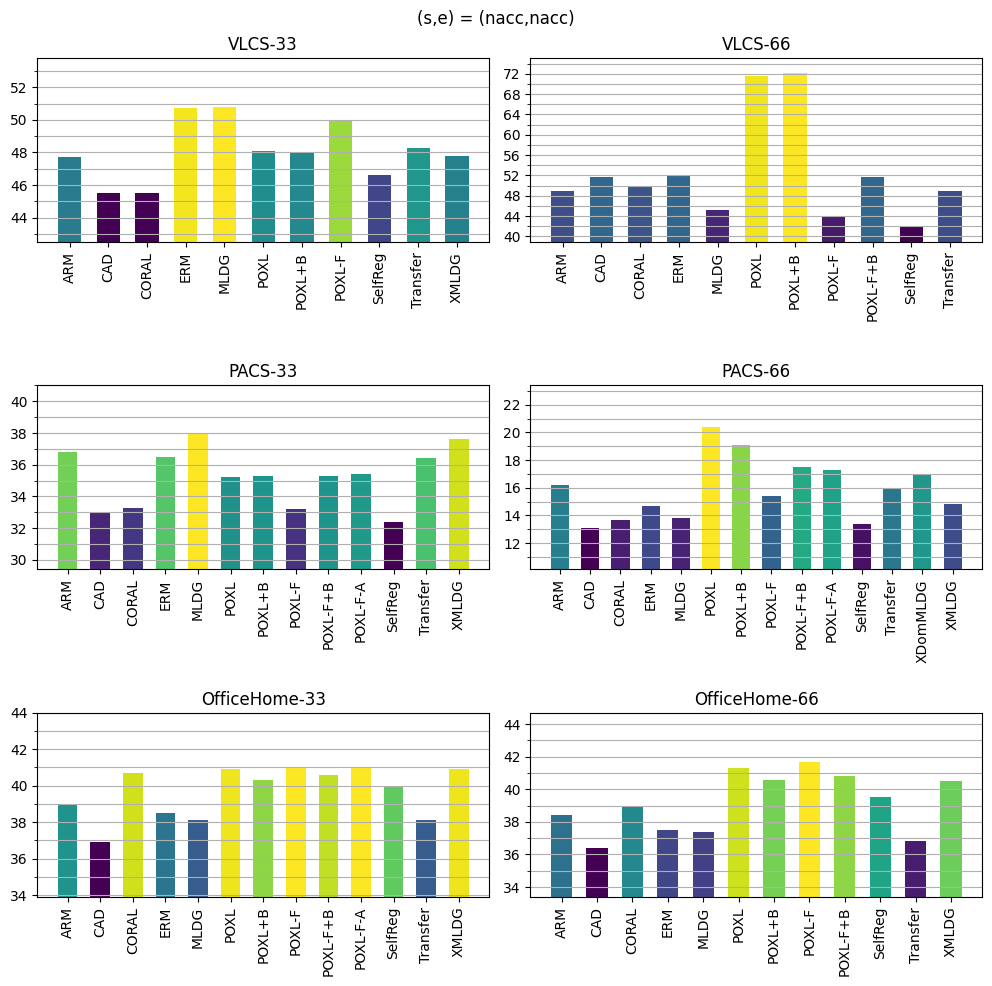

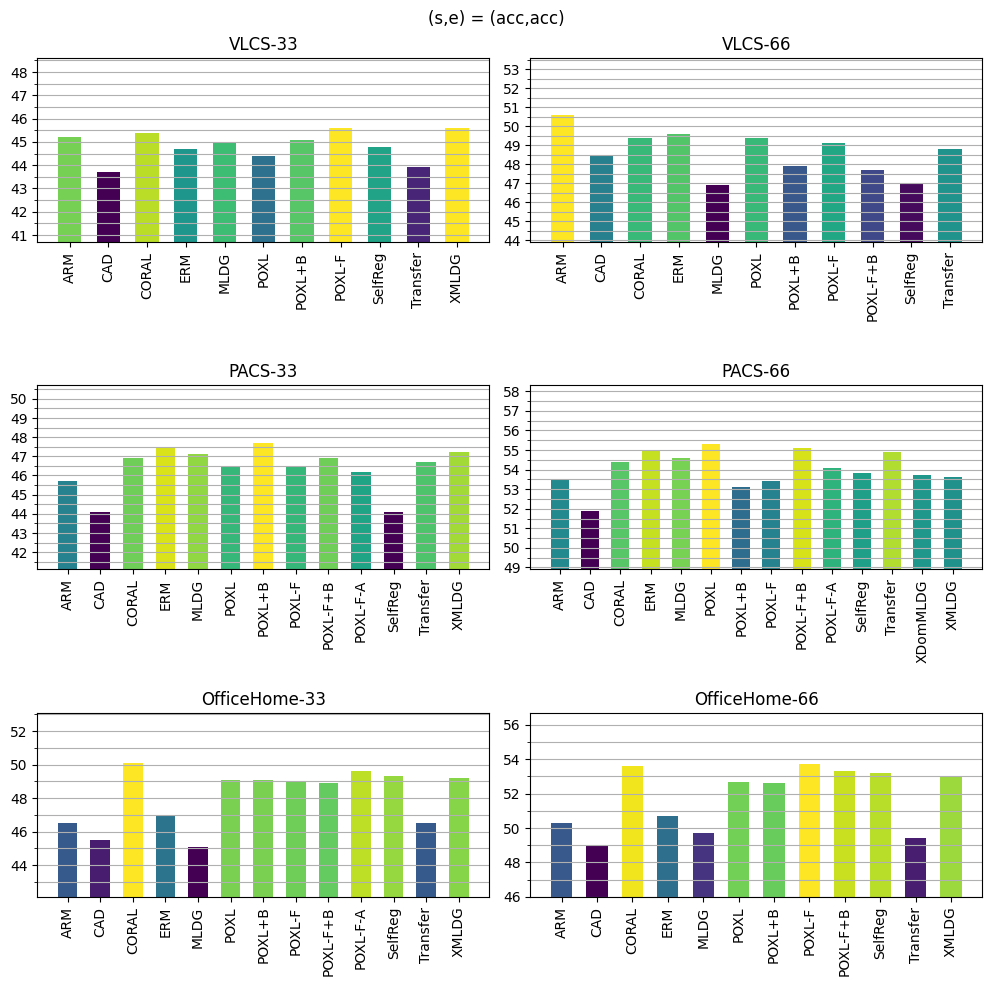

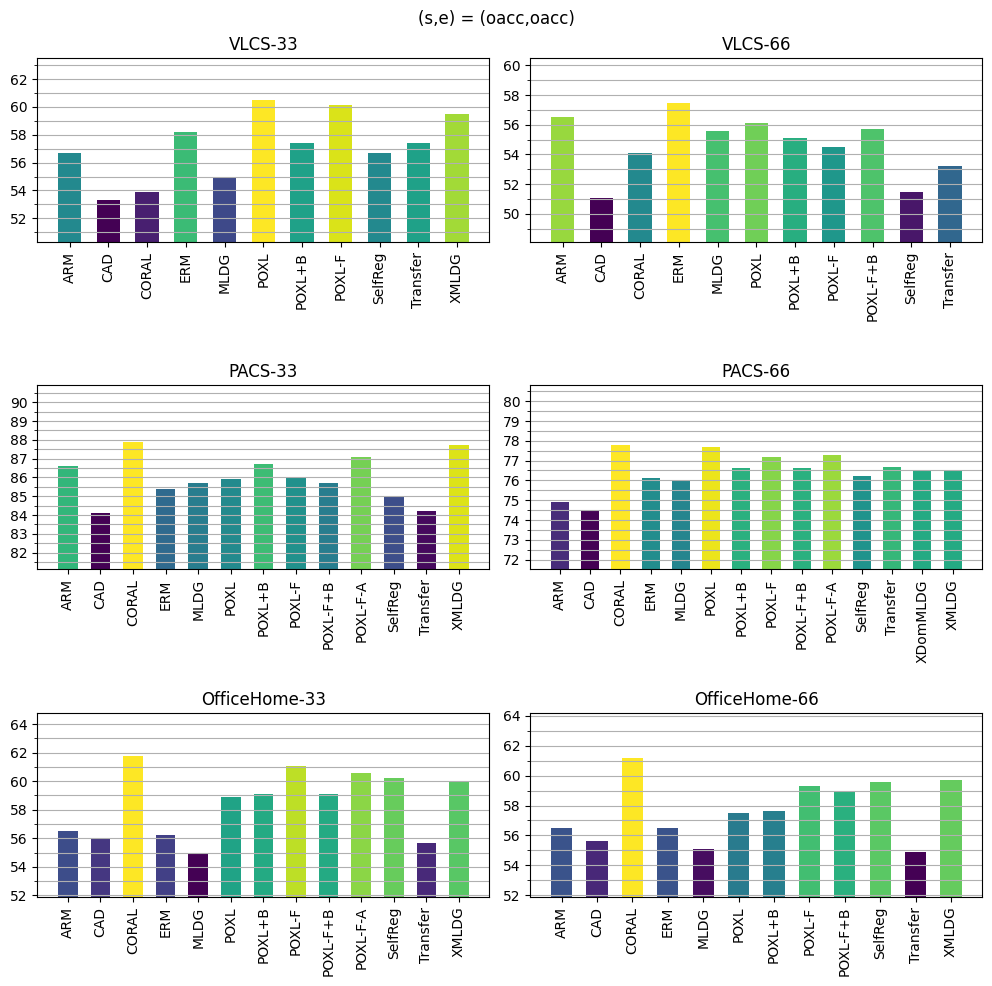

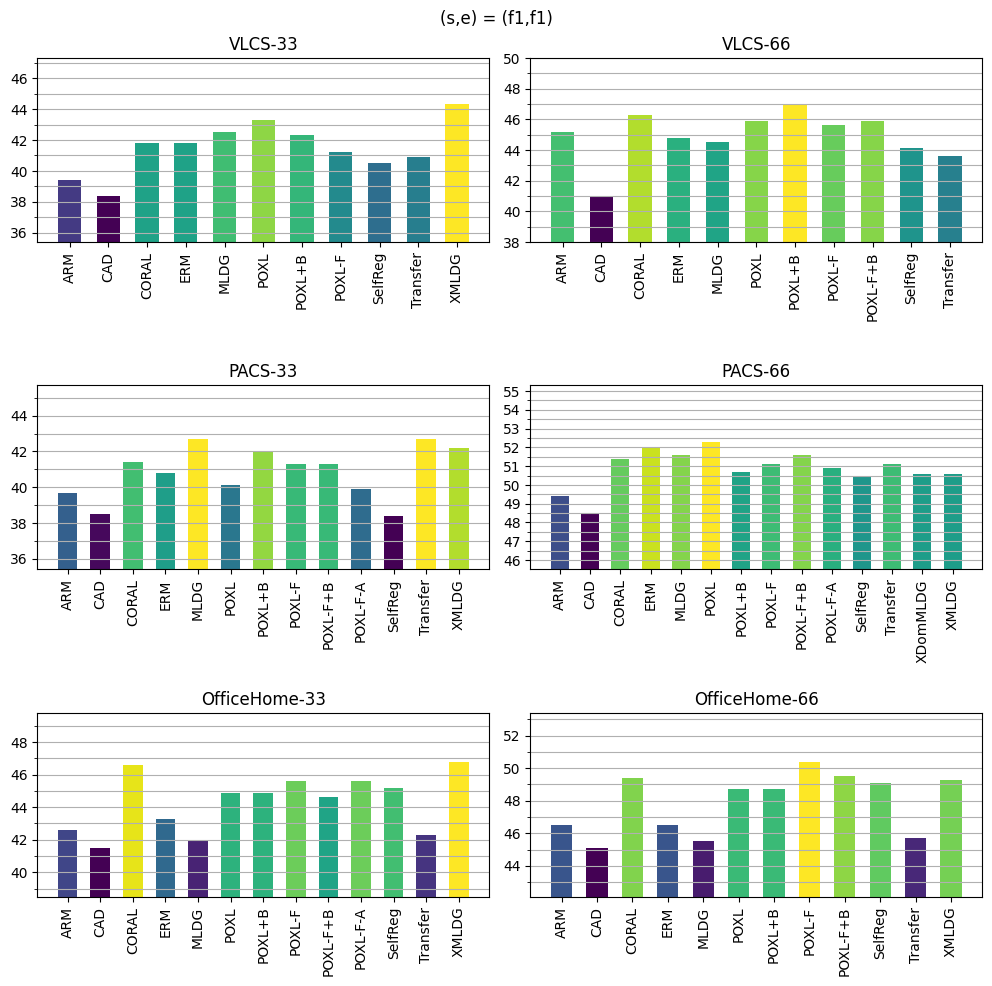

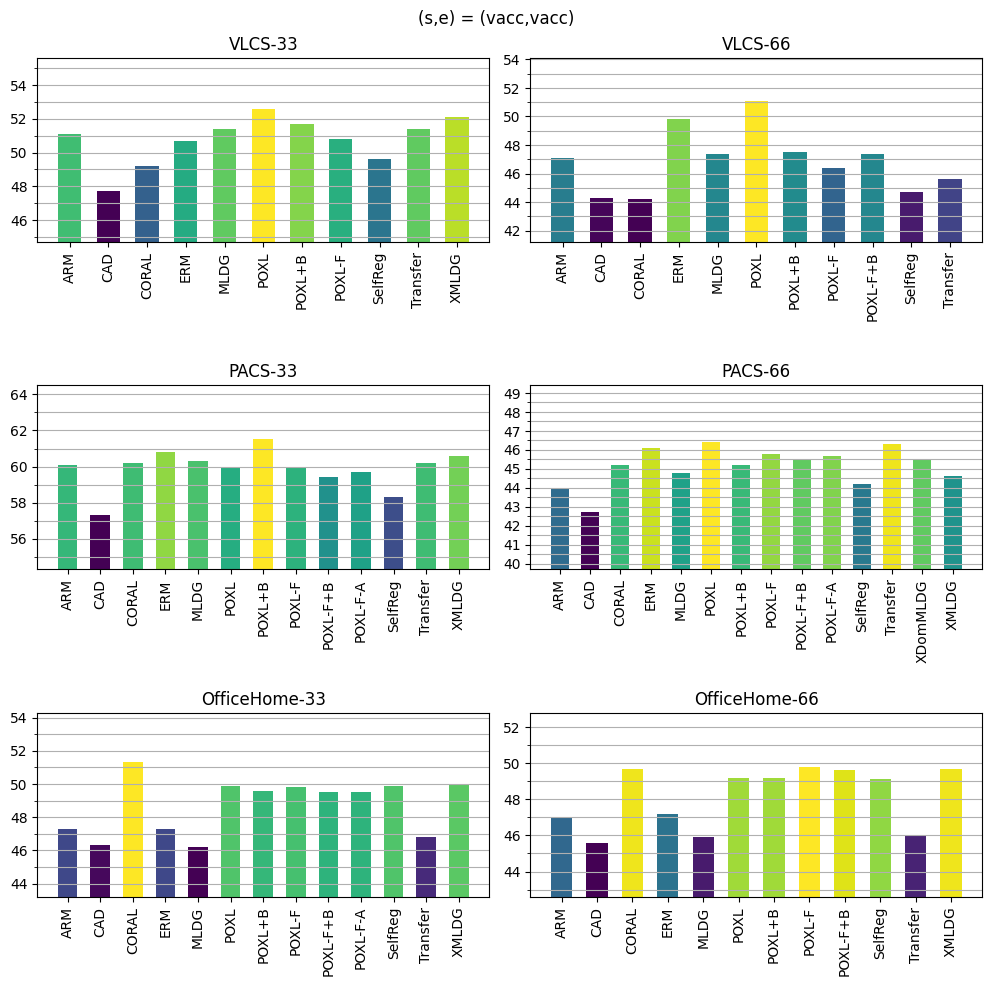

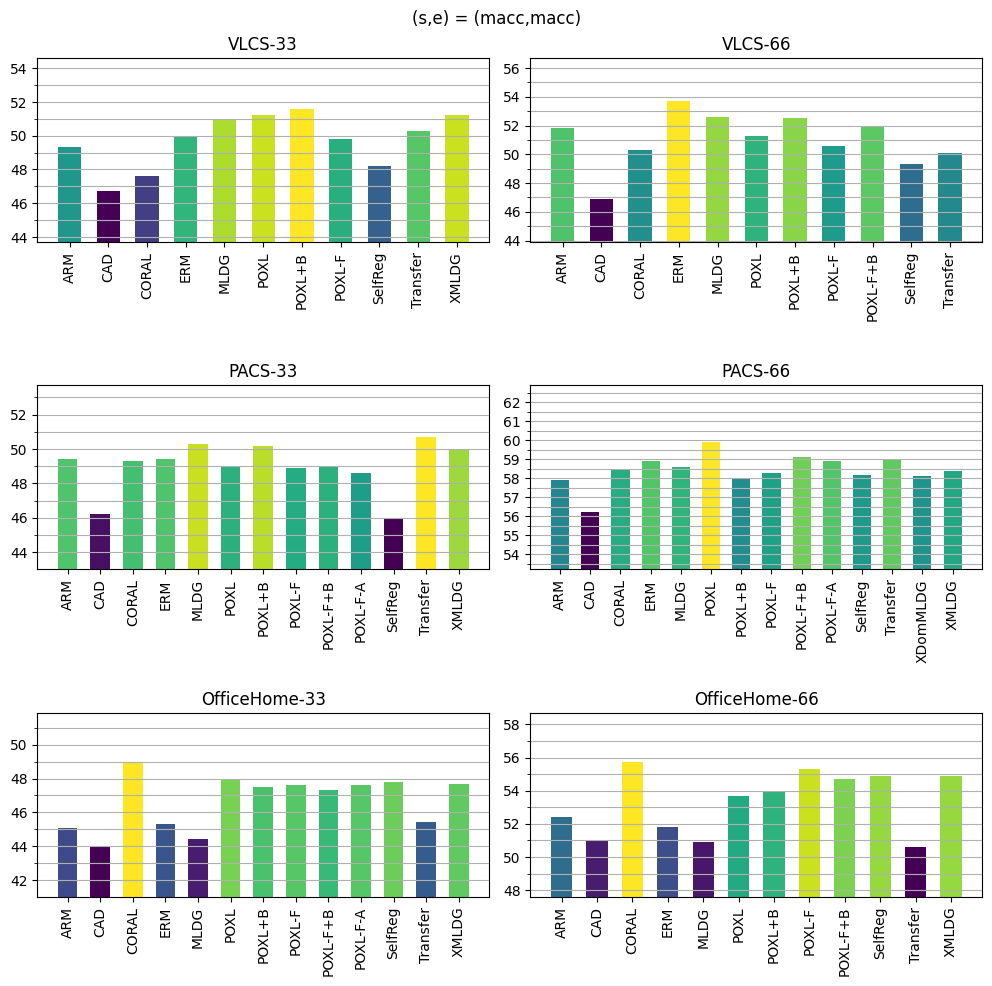

In [13]:
# remove non-baseline
data = df.loc[
    (df['algorithm'] != 'Intra') &
    (df['algorithm'] != 'SupCon') &
    (df['algorithm'] != 'Intra_XDom') &
    (df['algorithm'] != 'XDom') &
    (df['algorithm'] != 'XDomError') &
    (df['algorithm'] != 'XDomBatch')
]

overlap_list = ['33', '66']
dataset_list = list(df["dataset"].unique())
sl = list(data["selection_metric"].unique())
el = list(data["evaluation_metric"].unique())
sl_el = itertools.product(sl, el)
for s, e in sl_el:
    if e != s: continue
    # if e not in  ['macc', 'nacc']: continue
    # if e != 'f1' or s != 'f1': continue
    plot_results(data, s, e, overlap_list, dataset_list).show()

## Plot the stacked relationship between datasets and all overlaps
- The purpose is to provide a visualization of the the non-overlapping performance across data sets averaged over the different overlap cases

In [10]:
from matplotlib.ticker import AutoMinorLocator
def stack_plot_results(df, selec_metric, eval_metric):
    dataset_list = ['PACS','VLCS','OfficeHome']
    overlap_list = ['33', '66']
    color = ['#024b7a', '#44a5c2']
    
    fig, ax = plt.subplots(
        nrows = 1,
        ncols = len(dataset_list),
        #figsize=(10,10),
        figsize=(10,4),
        sharey=False)
    
    for i, dataset in enumerate(dataset_list):
        data = df.loc[
            (df['dataset'] == dataset) &
            (df['selection_metric'] == selec_metric) &
            (df['evaluation_metric'] == eval_metric) &
            (df['algorithm'] != 'SupCon') &
            #(df['algorithm'] != 'Intra') &
            #(df['algorithm'] != 'Intra_XDom') &
            (df['algorithm'] != 'XDomBatch')
        ].sort_values(by=['algorithm'], ascending=True)
        
        values = []
        for overlap in overlap_list:
            values.append(
                list(data.loc[(df['overlap'] == overlap)]['evaluation_value'])
            )
        values = np.array(values)
        
        # set_trace()
        # stack bar charts
        for j in range(values.shape[0]):
            ax[i].bar(
                x = list(data[data['overlap'] == overlap_list[j]]['algorithm'].unique()),
                height = values[j],
                bottom = np.sum(values[:j], axis=0),
                color=color[j],
                label=overlap_list[j]
            ) 
        ax[i].set_title(dataset)
        ax[i].set_ylabel = selec_metric
        ax[i].tick_params(axis='x', labelrotation=90)
        ax[i].grid(axis="y", which="both")
        ax[i].yaxis.set_minor_locator(AutoMinorLocator(2))
        
        if i == 0:
            handles, labels = ax[i].get_legend_handles_labels()
            fig.legend(
                handles,
                labels, 
                loc="upper center",
                title="Overlap Cases",
                ncols=len(overlap_list),
                bbox_to_anchor=(0.5, .93)
            )
    
    fig.suptitle(f"(s,e) = ({selec_metric},{eval_metric})")
    #fig.legend(loc="upper center", title="Overlap Case", ncols=2)
    fig.tight_layout(pad=3.0, w_pad=1.0)
    return fig

sl = list(df["selection_metric"].unique())
el = list(df["evaluation_metric"].unique())
sl_el = itertools.product(sl, el)
for s, e in sl_el:
    #if e != 'nacc' or s != 'nacc': continue
    #if s != 'nacc': continue
    if s != e: continue
    #stack_plot_results(df=df, selec_metric=s, eval_metric=e).show()

## Plot the relationship between "nacc" and "oacc"
- Could average across: datasets, overlaps, selection_metrics
    - Across datasets would be the most beneficial and easiest to justify
- Purpose of this plot is display the relationship between non-overlapping and overlapping class accuracies for different methods
- With `selec_metric='nacc'` across all datasets (even excluding VLCS anomally) XDom best accuracy and XDomError best non-overlapping accuracy
- Set the ylim and xlim with the zoom in plot to show the performance discrepancy
- Show the accuracy color gradient in the plot
- Use a zoomed in subplot for the results

(nacc, oacc)
(nacc, nacc)
(nacc, acc)
(nacc, vacc)
(nacc, macc)
(nacc, f1)
   marker algorithm       nacc       oacc        acc       macc       vacc  \
0       H     XMLDG  36.320000  65.560000  49.800000  51.960000  50.940000   
1       <  XDomMLDG  17.000000  74.400000  53.800000  58.000000  45.700000   
2       d  Transfer  37.416667  59.250000  47.200000  48.933333  48.350000   
3       D   SelfReg  35.633333  60.566667  48.083333  49.000000  48.100000   
4       *  POXL-F-A  31.233333  72.700000  50.333333  52.000000  51.966667   
5       P    POXL+B  42.566667  59.783333  48.300000  49.750000  51.166667   
6       p      POXL  42.900000  57.283333  46.766667  47.883333  50.083333   
7       s      MLDG  37.216667  60.933333  48.100000  50.450000  49.066667   
8       o       ERM  38.283333  60.716667  48.183333  50.150000  49.500000   
9       >     CORAL  36.983333  62.183333  49.266667  50.200000  49.583333   
10      X       CAD  36.100000  57.950000  46.416667  47.200000  47

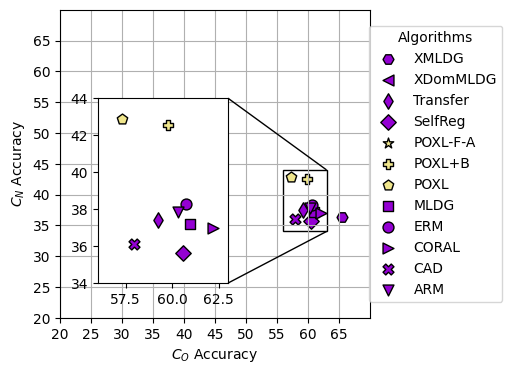

In [11]:
import math
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
color_metric = "av_acc"
x='oacc'
y='nacc'

def get_metric(data, eval_metric, selec_metric='nacc'):
    """Averaging across overlaps and datasets"""
    print(f"({selec_metric}, {eval_metric})")
    data = df.loc[
        #(df['dataset'] != 'VLCS') &
        # (df['dataset'] == 'OfficeHome') &
        (df['selection_metric'] == selec_metric) &  
        (df['evaluation_metric'] == eval_metric) &
        ((df['overlap'] == '33') | (df['overlap'] == '66')) &
        (df['algorithm'] != 'XDomBatch') &
#         (df['algorithm'] != 'POXL') &
        (df['algorithm'] != 'POXL-F+B') &
        (df['algorithm'] != 'POXL-F') &
        (df['algorithm'] != 'SupCon') &
        (df['algorithm'] != 'Intra') &
        (df['algorithm'] != 'Intra_XDom')
    ].sort_values(by='algorithm', ascending=True).reset_index(drop=True)
    
    cols = ['algorithm', 'overlap', 'dataset', 'evaluation_value']
    # print(data.groupby(cols).mean())
    metric_data = data.groupby('algorithm').mean(numeric_only=True).reset_index(names="algorithm")
    #print(metric_data)
    return metric_data


df_oacc = get_metric(df, 'oacc')
df_nacc = get_metric(df, 'nacc')
df_acc = get_metric(df, 'acc')
df_vacc = get_metric(df, 'vacc')
df_macc = get_metric(df, 'macc')
assert len(df_oacc) == len(df_nacc) == len(df_acc)

# dataframe 
data = pd.DataFrame(data={
    'marker': MARKERS[:len(df_oacc['algorithm'])],
    'algorithm': df_oacc['algorithm'],
    'nacc': df_nacc['evaluation_value'],
    'oacc': df_oacc['evaluation_value'],
    'acc': df_acc['evaluation_value'],
    'macc': df_macc['evaluation_value'],
    'vacc': df_vacc['evaluation_value'],
    'av_acc': (df_oacc['evaluation_value']+df_nacc['evaluation_value'])/2,
    'f1': get_metric(data, 'f1')['evaluation_value'],
    'diff': df_oacc['evaluation_value'] - df_nacc['evaluation_value'],
})
data = data.sort_values(by='algorithm', ascending=False).reset_index(drop=True)
print(data)
# TODO: scale  nacc and oacc for error line to be drawn
# colour map
my_cmap = plt.get_cmap("viridis")
def rescale(row, rows):
    return (row - np.min(rows)) / (np.max(rows) - np.min(rows))
    
rescale_lmbd = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))

# scatter plot
fig, ax = plt.subplots(figsize=(4,4))
assert len(MARKERS) >= len(data)
for index, row in data.iterrows():
    if "POXL" in row['algorithm']:
        color = "khaki"
    else:
        color = "darkviolet"
    s=ax.scatter(
#         x=rescale(row['nacc'], data['nacc']),
#         y=rescale(row['oacc'], data['oacc']),
        x=row[x],
        y=row[y],
        color=color,
        edgecolor="black",
        #color=my_cmap(rescale(row[color_metric], data[color_metric])),
        label=row['algorithm'],
        marker=row['marker'],
        s=mpl.rcParams['lines.markersize'] ** 2.3
    )
    
# ax.scatter(
#     x=data['nacc'],
#     y=data['oacc'],
#     c=rescale_lmbd(data[color_metric]),
#     label=list(data['algorithm']),
#     cmap=my_cmap,
#     s=mpl.rcParams['lines.markersize'] ** 2.3,
#     #markers=markers
# )
# ax.plot([0,1], [0,1], 'k--')
# ax.plot([30,70], [30,70], 'k--', linewidth=1)

# AXIS LABELS
# ax.set_title(("Classification accuracy discrepancies under\n"
#               "Partial-Overlap Domain Generalization"), 
#             fontsize=10)
ax.set_xlabel(AXIS_LABELS[x])
ax.set_ylabel(AXIS_LABELS[y])
ax.grid(axis="both", which="both")
# AXIS RANGE/VALUES
ax.set_ylim(20,70)
ax.set_xlim(20,70)
ax.set_yticks(np.arange(20,70,5))
ax.set_xticks(np.arange(20,70,5))
# LEGEND
ax.legend(loc='center right', bbox_to_anchor=(1.45, 0.5), title="Algorithms")


# ZOOM PLOT
#loc='upper left',
axins = zoomed_inset_axes(
    ax, 3, bbox_to_anchor=(.10, .09, .6, .5),
                   bbox_transform=ax.transAxes, loc=3)
for index, row in data.iterrows():
    if "POXL" in row['algorithm']:
        color = "khaki"
    else:
        color = "darkviolet"
    axins.scatter(
        x=row[x],
        y=row[y],
        color=color,
        edgecolor="black",
        #color=my_cmap(rescale(row[color_metric], data[color_metric])),
        label=row['algorithm'],
        marker=row['marker'],
        s=mpl.rcParams['lines.markersize'] ** 2.3
    )
axins.set_xlim(56, 63)
axins.set_ylim(34, 44)
# axins.yaxis.get_major_locator().set_params(nbins=2)
# axins.xaxis.get_major_locator().set_params(nbins=2)
# axins.tick_params(labelleft=False, labelbottom=False)
# axins.xticks(visible=False)
# axins.yticks(visible=False)
mark_inset(ax, axins, loc1=4, loc2=1, lw=1, fc="none", ec="black")

# COLORBAR
# cb = fig.colorbar(s, label=color_metric)
# cb_ticks = cb.get_ticks()
# cb_min = math.floor(min(data[color_metric]))
# cb_max = math.ceil(max(data[color_metric]))
# cb_steps = (cb_max - cb_min)/(len(cb_ticks)-1)
# cb_labels = np.arange(
#         start=cb_min,
#         stop=cb_max+cb_steps,
#         step=cb_steps,
#     ) 
# print("cb_labels:", cb_labels)
# cb.set_ticks(ticks=cb_ticks, labels=cb_labels)

# OTHER DRAWINGS
#ax.plot([35,65], [35,65], 'k--', linewidth=1)
# ax.plot([35,65], [50,50], 'k--', linewidth=2)
# ax.plot([50,50], [35,65], 'k--', linewidth=2)

plt.show()

## Create a scatter plot for each dataset
- Create a scatter plot for each dataset that averagers performance across multiple overlaps
- Also visualizes the effect of different selection metrics

AssertionError: 

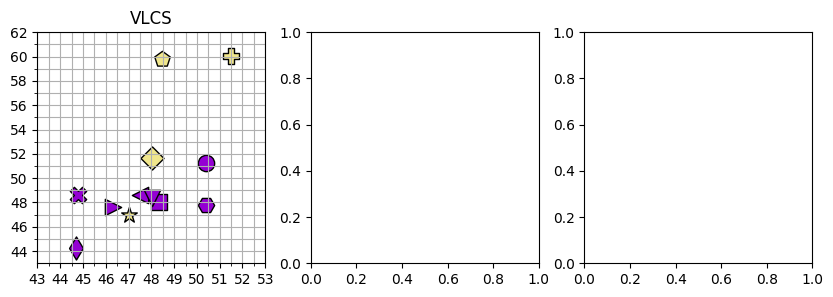

In [12]:
import math
from matplotlib.ticker import FormatStrFormatter

def get_metrics(
    data, eval_metric, selec_metric, dataset=None, overlap=None
    ):
    #print(f"({selec_metric}, {eval_metric}, {dataset})")
    data = df.loc[
        (df['selection_metric'] == selec_metric) &  
        (df['evaluation_metric'] == eval_metric) &
        (df['algorithm'] != 'XDomBatch') &
        (df['algorithm'] != 'XDom') &
        (df['algorithm'] != 'XDomError') &
        (df['algorithm'] != 'SupCon') &
        (df['algorithm'] != 'Intra') &
        (df['algorithm'] != 'Intra_XDom')
    ]
    if dataset is not None:
        data = data.loc[df['dataset'] == dataset]
    if overlap is not None:
        data = data.loc[df['overlap'] == overlap]
    else:
        data = data.loc[((df['overlap'] == '66') | (df['overlap'] == '33'))]

    data = data.sort_values(by='algorithm', ascending=True).reset_index(drop=True)
    cols = ['algorithm', 'overlap', 'dataset', 'evaluation_value']
    metric_data = data.groupby('algorithm').mean(numeric_only=True).reset_index(names="algorithm")
    return metric_data

def plot_dataset(
    df, dataset, ax, color_metric, selec_metric, x, y, overlap=None
    ):
    """Plot average across overlaps for each dataset"""
    num_major_ticks = 7
    algorithm=get_metrics(df, 'oacc', selec_metric, dataset=dataset, overlap=overlap)['algorithm']
    df_oacc = get_metrics(df, 'oacc', selec_metric, dataset=dataset, overlap=overlap)['evaluation_value']
    df_nacc = get_metrics(df, 'nacc', selec_metric, dataset=dataset, overlap=overlap)['evaluation_value']
    df_acc = get_metrics(df, 'acc', selec_metric, dataset=dataset, overlap=overlap)['evaluation_value']
    df_macc = get_metrics(df, 'macc', selec_metric, dataset=dataset, overlap=overlap)['evaluation_value']    
    df_f1 = get_metrics(df, 'f1', selec_metric, dataset=dataset, overlap=overlap)['evaluation_value']
    df_diff = df_oacc - df_nacc
    df_ave_acc = (df_oacc+df_nacc)/2
    assert len(df_oacc) == len(df_nacc) == len(df_acc) == len(algorithm)
    
    assert len(MARKERS) >= len(algorithm)

    # dataframe 
    data = pd.DataFrame(data={
        'marker': MARKERS[:len(algorithm)],
        'algorithm': algorithm,
        'nacc': df_nacc,
        'oacc': df_oacc,
        'acc': df_acc,
        'av_acc': df_ave_acc,
        'f1': df_f1,
        'macc': df_macc,
        'diff': df_diff,
    }).sort_values(by='algorithm', ascending=False).reset_index(drop=True)
    #print(data)
    
    # colour mapping
    my_cmap = plt.get_cmap("viridis")
    def rescale(row, rows):
        return (row - np.min(rows)) / (np.max(rows) - np.min(rows))
    
    # populate scatter plot
    for index, row in data.iterrows():
        if "POXL" in row['algorithm']:
            color = "khaki"
        else:
            color = "darkviolet"
        s=ax.scatter(
            x=row[x],
            y=row[y],
            #color=my_cmap(rescale(row[color_metric], data[color_metric])),
            color=color,
            edgecolor='black',
            label=row['algorithm'],
            marker=row['marker'],
            s=mpl.rcParams['lines.markersize'] ** 2.75
        )
        
    # AXIS LABELS
    # ax.set_title(f"{dataset}-{selec_metric}")
    ax.set_title(f"{dataset}")
    ax.grid(axis="both", which="both")
    # AXIS RANGE/VALUES
    # AXIS X
    x_min = math.floor(min(data[x]))-1
    x_max = math.ceil(max(data[x]))+1
    x_steps = (x_max - x_min)/num_major_ticks
    ax.set_xlim(x_min, x_max)
    ax.set_xticks(np.arange(x_min, x_max, x_steps))
    # AXIS Y
    y_min = math.floor(min(data[y]))-1
    y_max = math.ceil(max(data[y]))+1
    y_steps = (y_max - y_min)/num_major_ticks
    ax.set_ylim(y_min, y_max)
    ax.set_yticks(np.arange(y_min, y_max, y_steps))

    ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    
    ax.get_yaxis().set_major_locator(MaxNLocator(integer=True))
    ax.get_xaxis().set_major_locator(MaxNLocator(integer=True))
    
    return ax

dataset_list = list(df['dataset'].unique())
x='av_acc'
y='nacc'
color_metric='acc'

for selec_metric in ['nacc', 'acc', 'oacc', 'f1']:
    fig, ax = plt.subplots(
        nrows=1, ncols=len(dataset_list), figsize=(10,3), sharey=False)

    for i, dataset in enumerate(dataset_list):
        last_ax = plot_dataset(
            df=df, 
            ax=ax[i], 
            selec_metric=selec_metric,
            dataset=dataset,
            x=x,
            y=y,
            color_metric=color_metric)

    # LABELS
    ax[0].set_ylabel(AXIS_LABELS[y], fontsize=12)
    ax[1].set_xlabel(AXIS_LABELS[x], fontsize=12)
    # LEGEND
    ax[-1].legend(loc='center right', bbox_to_anchor=(1.7, 0.5), title="Algorithms")

    fig.show()

## Create a scatter plot for each dataset for each overlap
- Also visualizes the effect of different selection metrics

In [ ]:
dataset_list = list(df['dataset'].unique())
x='macc'
y='nacc'
color_metric='acc'
selec_metric='nacc'

for overlap in ['33', '66']:
    fig, ax = plt.subplots(
        nrows=1, ncols=len(dataset_list), figsize=(10,3), sharey=False)

    for i, dataset in enumerate(dataset_list):
        last_ax = plot_dataset(
            df, 
            dataset, 
            ax[i], 
            selec_metric=selec_metric,
            x=x,
            y=y,
            color_metric=color_metric,
            overlap=overlap)

    ax[0].set_ylabel(y)
    # LEGEND
    ax[-1].legend(loc='center right', bbox_to_anchor=(1.7, 0.5), title="Algorithms")
    ax[1].set_xlabel(AXIS_LABELS[x], fontsize=12)

    fig.show()